## Import Packages

In [55]:
import rdkit
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole

from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics 

## Read files and create dataframe with Smiles

In [2]:
df_smiles1 = pd.read_csv('tested_molecules.csv')
df_smiles2 = pd.read_csv('tested_molecules_v2.csv')
df_smiles_tested = pd.concat([df_smiles1, df_smiles2], ignore_index=True)

df_smiles_untested = pd.read_csv('untested_molecules.csv')

df_smiles_pca = pd.concat([df_smiles_tested,df_smiles_untested], ignore_index=True)

## Check descriptor values for all Smiles

In [3]:
def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

In [4]:
def getListDescriptorValues(df):
    allDescrs = []
    for _, row in df.iterrows():
        mol = row['SMILES']
        m = Chem.MolFromSmiles(mol)
        descriptors = getMolDescriptors(m)
        allDescrs.append(descriptors)
    return allDescrs

In [5]:
df_descr = pd.DataFrame(getListDescriptorValues(df_smiles_pca))

## Data cleaning

In [6]:
bad_descr=[]
for i in df_descr.columns:
    if df_descr[i].nunique() == 1:
        bad_descr.append(i)
print(bad_descr)       
df_nonzero=df_descr.drop(columns=bad_descr)

['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_azide', 'fr_isocyan', 'fr_isothiocyan', 'fr_prisulfonamd']


In [7]:
corrThreshold = 0.90


correlation_mat = df_nonzero.corr()
upper_tri = correlation_mat.where(np.triu(np.ones(correlation_mat.shape),k=1).astype(bool)) 
to_drop = [column for column in upper_tri.columns if any(upper_tri[column].abs() > corrThreshold)] 
df_noCorr = df_nonzero.drop(columns=to_drop)


df_noCorr.shape

(12000, 164)

## Scale data & perform PCA

In [8]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_noCorr)

pca = PCA(n_components=0.9)

principalComponents = pca.fit_transform(df_scaled)
principalDf = pd.DataFrame(data = principalComponents)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

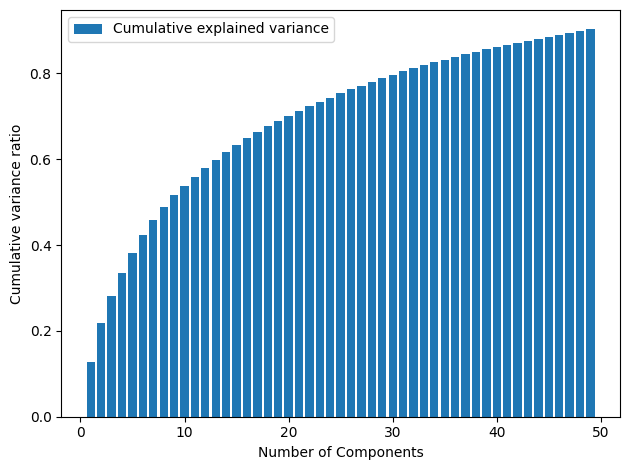

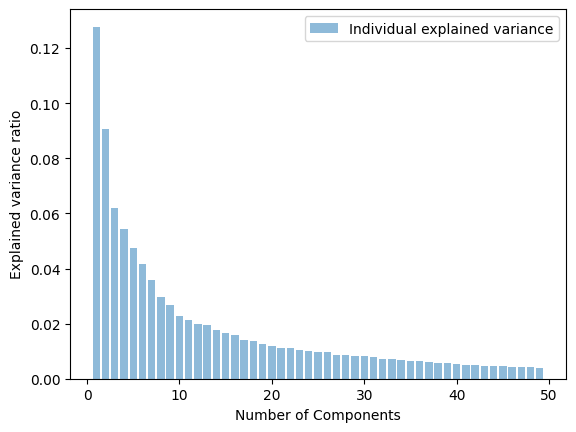

In [9]:
plt.bar(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, align='center',label='Cumulative explained variance');
plt.ylabel('Cumulative variance ratio')
plt.xlabel('Number of Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#scree plot om aantal PCA te bepalen
plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance');
plt.ylabel('Explained variance ratio')
plt.xlabel('Number of Components')
plt.legend(loc='best')
plt.show()

## Split data for testing

### Training & test set

In [10]:
# Split the data into training and testing sets

train_features = principalDf.iloc[0:2000]
train_labels = np.array(df_smiles_tested['ALDH1_inhibition'])

test_features = principalDf.iloc[2000::]

#check the shapes
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)


Training Features Shape: (2000, 49)
Training Labels Shape: (2000,)
Testing Features Shape: (10000, 49)


## Predictor models

In [71]:
KN_reg = neighbors.KNeighborsRegressor(n_neighbors=5)
KN_reg.fit(train_features, train_labels)

KNeighborsRegressor()

Predict wheter or not inhibitor

In [72]:
KN_pred = KN_reg.predict(test_features)

Select best 100 Smiles

In [74]:
to_be_predicted = 100 #test_labels.sum() #100 in geval van assignment

d={'SMILES':df_smiles_untested['SMILES'],'predictions':KN_pred}
best_scores = pd.DataFrame(d).nlargest(to_be_predicted,columns='predictions')

In [77]:
best_scores.to_csv('Best_100_Smiles.csv',columns=['SMILES'],index=False)

In [78]:
pd.read_csv('Best_100_Smiles')

,SMILES
0,O=C(NCCOc1ccc(Cl)cc1)C1CCCCC1
1,COc1ccc(C(=O)NCC(=O)NC2=[NH+]CCS2)cc1
2,CCOC(=O)c1ccc(NC(=O)C2(c3ccccc3)CCCC2)cc1
3,Cc1cc(OC(=O)Cc2cccc3ccccc23)c([N+](=O)[O-])c([...
4,CC(C(=O)N1CCCC1)c1ccc([N+](=O)[O-])cc1
...,...
95,CC1=CCC(C(=O)[O-])C(C(=O)Nc2nc3ccc(S(C)(=O)=O)...
96,O=[N+]([O-])c1cc(S(=O)(=O)c2ccc(N3CCCCC3)c([N+...
97,CCOC(=O)c1sc(NC(=O)COC(=O)CNC(=O)c2ccco2)c(C(=...
98,O=C(CNC(=S)N(Cc1ccccc1F)C1CCCCC1)NC1CC1
